In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from prophet import Prophet
from scipy import stats
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error


/Users/timhong/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Single Regressor

In [2]:
data = pd.read_excel("owid-covid-data.xlsx")

In [3]:
country_list = [
    'Norway', 'Finland', 'Lithuania', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Denmark', 'Switzerland', 'Poland'
]

selected_data = data[data['location'].isin(country_list)]
selected_data.head()



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


In [4]:
data_clean = selected_data[["location", "date", "new_cases"]]
data_clean.head()

,location,date,new_cases
28497,Belgium,2020-01-03,0.0
28498,Belgium,2020-01-04,0.0
28499,Belgium,2020-01-05,0.0
28500,Belgium,2020-01-06,0.0
28501,Belgium,2020-01-07,0.0


## Data Prep

### Dates

In [19]:
# missing values?
missing_values_count_before = data_clean['new_cases'].isnull().sum()
print(missing_values_count_before)


13


In [20]:
# Subset the dataset
data_clean_subset = data_clean[(data_clean['date'] >= '2020-03-01') & (data_clean['date'] <= '2023-06-30')]

In [21]:
# missing values?
missing_values_count_after = data_clean_subset['new_cases'].isnull().sum()
print(missing_values_count_after)

0


### Outliers

Prophet is robust to outliers, so we won't remove them!

In [22]:
cleaned_df = data_clean_subset.copy()

cleaned_df.head()

,location,date,new_cases
28555,Belgium,2020-03-01,0.0
28556,Belgium,2020-03-02,0.0
28557,Belgium,2020-03-03,18.0
28558,Belgium,2020-03-04,19.0
28559,Belgium,2020-03-05,34.0


## Prophet 

In [14]:
# remove location and store it separately
location_names = cleaned_df['location'].unique()

prophet_df = cleaned_df.drop(columns= 'location')
prophet_df.head()

,date,new_cases
28555,2020-03-01,0.0
28556,2020-03-02,0.0
28557,2020-03-03,18.0
28558,2020-03-04,19.0
28559,2020-03-05,34.0


### Grid Search to Tune Hyperparameters

In [27]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Assuming you have a DataFrame data_prepped with a 'new_cases' column, 'date' as the index, and 'location' column
# Make sure 'date' is set as the index

# Define features and target variable
X = cleaned_df.drop('new_cases', axis=1)
y = cleaned_df['new_cases']

# Initialize hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Create an empty DataFrame to store results
initial_results_df = pd.DataFrame(columns=['location', 'initial_rmse'])

# Get unique locations
locations = X['location'].unique()

# Iterate over locations
for location in tqdm(locations, desc="Grid Search Progress"):
    print(f"\nPerforming grid search for location: {location}")

    # Filter data for the current location
    df_location = cleaned_df[cleaned_df['location'] == location].reset_index()

    # Prepare data for Prophet
    df_prophet = df_location[['date', 'new_cases']]
    df_prophet = df_prophet.rename(columns={'date': 'ds', 'new_cases': 'y'})

    # Split the data into training and testing sets
    train_size = int(len(df_prophet) * 0.9884963)
    train_data, test_data = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

    # Initialize best hyperparameters and RMSE
    best_params = None
    best_rmse = float('inf')

    # Iterate over hyperparameter combinations
    for params in tqdm(list(ParameterGrid(param_grid)), desc="Hyperparameter Search Progress", leave=False):
        # Initialize Prophet model
        prophet_model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            seasonality_mode=params['seasonality_mode']
        )

        # Fit the model
        prophet_model.fit(train_data)

        # Make predictions on the test set
        future = prophet_model.make_future_dataframe(periods=len(test_data))
        forecast = prophet_model.predict(future)

        # Calculate RMSE
        rmse = ((forecast.loc[train_size:, 'yhat'] - test_data['y'])**2).mean()**0.5

        # Update best hyperparameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    print(f"Best hyperparameters for {location}: {best_params}")
    print(f"Best RMSE for {location}: {best_rmse}")

    # Store results in the DataFrame
    initial_results_df = pd.concat([initial_results_df, pd.DataFrame({'location': [location], 'initial_rmse': [best_rmse]})], ignore_index=True)

# Print or save the results DataFrame as needed
initial_results_df


Grid Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Performing grid search for location: Belgium


14:35:43 - cmdstanpy - INFO - Chain [1] start processing
14:35:43 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Belgium: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Belgium: 189.55977216953372

Performing grid search for location: Denmark


14:36:03 - cmdstanpy - INFO - Chain [1] start processing
14:36:03 - cmdstanpy - INFO - Chain [1] done processing
14:36:03 - cmdstanpy - INFO - Chain [1] start processing
14:36:03 - cmdstanpy - INFO - Chain [1] done processing
14:36:03 - cmdstanpy - INFO - Chain [1] start processing
14:36:03 - cmdstanpy - INFO - Chain [1] done processing
14:36:03 - cmdstanpy - INFO - Chain [1] start processing
14:36:03 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:05 - cmdstanpy - INFO - Chain [1] start processing
14:36:05 - cmdstanpy - INFO - Chain [1] done processing
14:36:05 - cmdstanpy - INFO - Chain [1] start processing
14:36:05 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Denmark: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Denmark: 280.6922473691571

Performing grid search for location: Finland


14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing
14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing
14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing
14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing
14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing
14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing
14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing
14:36:28 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1] done processing
14:36:28 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Finland: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Finland: 74.18896562132556

Performing grid search for location: Ireland


14:36:44 - cmdstanpy - INFO - Chain [1] start processing
14:36:44 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:45 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:45 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:45 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:47 - cmdstanpy - INFO - Chain [1] start processing
14:36:47 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Ireland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Ireland: 49.00251190282901

Performing grid search for location: Italy


14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Italy: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Italy: 3067.5526722997865

Performing grid search for location: Lithuania


14:37:22 - cmdstanpy - INFO - Chain [1] start processing
14:37:22 - cmdstanpy - INFO - Chain [1] done processing
14:37:22 - cmdstanpy - INFO - Chain [1] start processing
14:37:22 - cmdstanpy - INFO - Chain [1] done processing
14:37:22 - cmdstanpy - INFO - Chain [1] start processing
14:37:22 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:24 - cmdstanpy - INFO - Chain [1] start processing
14:37:24 - cmdstanpy - INFO - Chain [1] done processing
14:37:24 - cmdstanpy - INFO - Chain [1] start processing
14:37:24 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Lithuania: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Lithuania: 29.269415607445772

Performing grid search for location: Norway


14:37:42 - cmdstanpy - INFO - Chain [1] start processing
14:37:42 - cmdstanpy - INFO - Chain [1] done processing
14:37:42 - cmdstanpy - INFO - Chain [1] start processing
14:37:42 - cmdstanpy - INFO - Chain [1] done processing
14:37:42 - cmdstanpy - INFO - Chain [1] start processing
14:37:43 - cmdstanpy - INFO - Chain [1] done processing
14:37:43 - cmdstanpy - INFO - Chain [1] start processing
14:37:43 - cmdstanpy - INFO - Chain [1] done processing
14:37:43 - cmdstanpy - INFO - Chain [1] start processing
14:37:43 - cmdstanpy - INFO - Chain [1] done processing
14:37:43 - cmdstanpy - INFO - Chain [1] start processing
14:37:43 - cmdstanpy - INFO - Chain [1] done processing
14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1] done processing
14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1] done processing
14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Norway: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Norway: 44.62782025421469

Performing grid search for location: Poland


14:38:03 - cmdstanpy - INFO - Chain [1] start processing
14:38:03 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing
14:38:06 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Poland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Poland: 214.51318550494773

Performing grid search for location: Switzerland


14:38:26 - cmdstanpy - INFO - Chain [1] start processing
14:38:26 - cmdstanpy - INFO - Chain [1] done processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] done processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] done processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] done processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Switzerland: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Switzerland: 808.5128246268254

Performing grid search for location: United Kingdom


14:38:47 - cmdstanpy - INFO - Chain [1] start processing
14:38:47 - cmdstanpy - INFO - Chain [1] done processing
14:38:47 - cmdstanpy - INFO - Chain [1] start processing
14:38:47 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:49 - cmdstanpy - INFO - Chain [1] done processing
14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:49 - cmdstanpy - INFO - Chain [1] done processing
14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:49 - cmdstanpy - INFO - Chain [1] done processing
14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:49 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for United Kingdom: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for United Kingdom: 174.16906333052492


,location,initial_rmse
0,Belgium,189.559772
1,Denmark,280.692247
2,Finland,74.188966
3,Ireland,49.002512
4,Italy,3067.552672
5,Lithuania,29.269416
6,Norway,44.627820
7,Poland,214.513186
8,Switzerland,808.512825
9,United Kingdom,174.169063


Belgium: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Belgium: 189.55977216953372

Best hyperparameters for Denmark: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Denmark: 280.6922473691571

Best hyperparameters for Finland: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Finland: 74.18896562132556

Best hyperparameters for Ireland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Ireland: 49.00251190282901

Best hyperparameters for Italy: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Italy: 3067.5526722997865

Best hyperparameters for Lithuania: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Lithuania: 29.269415607445772

Best hyperparameters for Norway: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Norway: 44.62782025421469

Best hyperparameters for Poland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Poland: 214.51318550494773

Best hyperparameters for Switzerland: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Switzerland: 808.5128246268254

Best hyperparameters for United Kingdom: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for United Kingdom: 174.16906333052492

In [54]:
## Storing params
belgium_params = {
    'changepoint_prior_scale': 0.1,
    'holidays_prior_scale': 0.01,
    'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 0.1
}
denmark_params = {'changepoint_prior_scale': 0.1, 
                  'holidays_prior_scale': 0.01, 
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 0.01}

finland_params = {'changepoint_prior_scale': 0.01, 
                  'holidays_prior_scale': 0.01, 
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 0.01}

ireland_params = {'changepoint_prior_scale': 0.1, 
                  'holidays_prior_scale': 0.01, 
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 0.01}

italy_params = {'changepoint_prior_scale': 0.01, 
                'holidays_prior_scale': 0.01, 
                'seasonality_mode': 'multiplicative', 
                'seasonality_prior_scale': 0.01}

lithuania_params = {'changepoint_prior_scale': 0.1, 
                    'holidays_prior_scale': 0.01, 
                    'seasonality_mode': 'multiplicative', 
                    'seasonality_prior_scale': 0.1}

norway_params = {'changepoint_prior_scale': 0.1, 
                 'holidays_prior_scale': 0.01, 
                 'seasonality_mode': 'multiplicative', 
                 'seasonality_prior_scale': 0.01}

poland_params = {'changepoint_prior_scale': 0.1, 
                 'holidays_prior_scale': 0.01, 
                 'seasonality_mode': 'multiplicative', 
                 'seasonality_prior_scale': 0.1}

swiss_params = {'changepoint_prior_scale': 0.01, 
                'holidays_prior_scale': 0.01, 
                'seasonality_mode': 'multiplicative', 
                'seasonality_prior_scale': 0.01}

uk_params = {'changepoint_prior_scale': 0.1, 
             'holidays_prior_scale': 0.01, 
             'seasonality_mode': 'multiplicative', 
             'seasonality_prior_scale': 0.1}



## Adding National Holidays and COVID Lockdown Dates
I want to use the holidays feature of prophet to add 1). National Holidays, and 2). important lockdown-related dates, by country. I will add these lockdown dates as one-off (non-recurring) holidays!

### Defining Lockdown Dates

In [28]:
# Belgium
belgium_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-20', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-06', 'lower_window': 0, 'ds_upper': '2021-04-26'}
])
for t_col in ['ds', 'ds_upper']:
    belgium_lockdowns[t_col] = pd.to_datetime(belgium_lockdowns[t_col])
belgium_lockdowns['upper_window'] = (belgium_lockdowns['ds_upper'] - belgium_lockdowns['ds']).dt.days

# Denmark - strict and fast
denmark_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-15'}
])
for t_col in ['ds', 'ds_upper']:
    denmark_lockdowns[t_col] = pd.to_datetime(denmark_lockdowns[t_col])
denmark_lockdowns['upper_window'] = (denmark_lockdowns['ds_upper'] - denmark_lockdowns['ds']).dt.days

# Finland
finland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2021-03-08', 'lower_window': 0, 'ds_upper': '2021-03-30'}
])
for t_col in ['ds', 'ds_upper']:
    finland_lockdowns[t_col] = pd.to_datetime(finland_lockdowns[t_col])
finland_lockdowns['upper_window'] = (finland_lockdowns['ds_upper'] - finland_lockdowns['ds']).dt.days

# Ireland
ireland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2021-01-26', 'lower_window': 0, 'ds_upper': '2021-03-19'}
])
for t_col in ['ds', 'ds_upper']:
    ireland_lockdowns[t_col] = pd.to_datetime(ireland_lockdowns[t_col])
ireland_lockdowns['upper_window'] = (ireland_lockdowns['ds_upper'] - ireland_lockdowns['ds']).dt.days

# Italy
italy_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-08', 'lower_window': 0, 'ds_upper': '2020-05-04'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-06'}
])
for t_col in ['ds', 'ds_upper']:
    italy_lockdowns[t_col] = pd.to_datetime(italy_lockdowns[t_col])
italy_lockdowns['upper_window'] = (italy_lockdowns['ds_upper'] - italy_lockdowns['ds']).dt.days

# Lithuania
lithuania_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-04-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-07', 'lower_window': 0, 'ds_upper': '2021-12-31'}
])
for t_col in ['ds', 'ds_upper']:
    lithuania_lockdowns[t_col] = pd.to_datetime(lithuania_lockdowns[t_col])
lithuania_lockdowns['upper_window'] = (lithuania_lockdowns['ds_upper'] - lithuania_lockdowns['ds']).dt.days

# Norway
norway_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-08'}
])
for t_col in ['ds', 'ds_upper']:
    norway_lockdowns[t_col] = pd.to_datetime(norway_lockdowns[t_col])
norway_lockdowns['upper_window'] = (norway_lockdowns['ds_upper'] - norway_lockdowns['ds']).dt.days

# Poland
poland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-31'},
    {'holiday': 'lockdown_3', 'ds': '2021-03-11', 'lower_window': 0, 'ds_upper': '2021-04-28'}
])
for t_col in ['ds', 'ds_upper']:
    poland_lockdowns[t_col] = pd.to_datetime(poland_lockdowns[t_col])
poland_lockdowns['upper_window'] = (poland_lockdowns['ds_upper'] - poland_lockdowns['ds']).dt.days

# Switzerland
swiss_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    swiss_lockdowns[t_col] = pd.to_datetime(swiss_lockdowns[t_col])
swiss_lockdowns['upper_window'] = (swiss_lockdowns['ds_upper'] - swiss_lockdowns['ds']).dt.days

# United Kingdom
uk_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2021-01-06', 'lower_window': 0, 'ds_upper': '2022-03-08'}
])
for t_col in ['ds', 'ds_upper']:
    uk_lockdowns[t_col] = pd.to_datetime(uk_lockdowns[t_col])
uk_lockdowns['upper_window'] = (uk_lockdowns['ds_upper'] - uk_lockdowns['ds']).dt.days

For national holidays, I will specify.

## Fitting Models to Each Country

In [51]:
# renaming variables & splitting into separate datasets by country
prophet_df_og = cleaned_df.rename(columns={'date': 'ds', 'new_cases': 'y'})

prophet_df = prophet_df_og.copy()
# Convert location to lowercase
prophet_df['location'] = prophet_df['location'].str.lower()

# Initialize variables for each location DataFrame
belgium_df = pd.DataFrame()
denmark_df = pd.DataFrame()
finland_df = pd.DataFrame()
ireland_df = pd.DataFrame()
italy_df = pd.DataFrame()
lithuania_df = pd.DataFrame()
norway_df = pd.DataFrame()
poland_df = pd.DataFrame()
switzerland_df = pd.DataFrame()
united_kingdom_df = pd.DataFrame()

# Iterate through unique locations and assign the data to respective DataFrames
for location in prophet_df['location'].unique():
    current_location_df = prophet_df[prophet_df['location'] == location].copy()
    # Assign the data to the respective DataFrame variable
    globals()[f"{location}_df"] = current_location_df

# Now you can access each DataFrame by its variable name, for example, belgium_df, denmark_df, etc.



In [52]:
uk_df = prophet_df_og[prophet_df_og['location'] == 'United Kingdom']
uk_df.head()



,location,ds,y
321453,United Kingdom,2020-03-01,12.0
321454,United Kingdom,2020-03-02,4.0
321455,United Kingdom,2020-03-03,20.0
321456,United Kingdom,2020-03-04,41.0
321457,United Kingdom,2020-03-05,58.0


In [53]:
split_index = int(len(belgium_df) * 0.9884963)
## setting train/test splits for each country
# Drop the 'location' column from the Belgium DataFrame and split into training and testing sets
belgium_df = belgium_df.drop('location', axis=1)
train_belgium = belgium_df.iloc[:split_index]
test_belgium = belgium_df.iloc[split_index:]

# Drop the 'location' column from the Denmark DataFrame and split into training and testing sets
denmark_df = denmark_df.drop('location', axis=1)
train_denmark = denmark_df.iloc[:split_index]
test_denmark = denmark_df.iloc[split_index:]

# Drop the 'location' column from the Finland DataFrame and split into training and testing sets
finland_df = finland_df.drop('location', axis=1)
train_finland = finland_df.iloc[:split_index]
test_finland = finland_df.iloc[split_index:]

# Drop the 'location' column from the Ireland DataFrame and split into training and testing sets
ireland_df = ireland_df.drop('location', axis=1)
train_ireland = ireland_df.iloc[:split_index]
test_ireland = ireland_df.iloc[split_index:]

# Drop the 'location' column from the Italy DataFrame and split into training and testing sets
italy_df = italy_df.drop('location', axis=1)
train_italy = italy_df.iloc[:split_index]
test_italy = italy_df.iloc[split_index:]

# Drop the 'location' column from the Lithuania DataFrame and split into training and testing sets
lithuania_df = lithuania_df.drop('location', axis=1)
train_lithuania = lithuania_df.iloc[:split_index]
test_lithuania = lithuania_df.iloc[split_index:]

# Drop the 'location' column from the Norway DataFrame and split into training and testing sets
norway_df = norway_df.drop('location', axis=1)
train_norway = norway_df.iloc[:split_index]
test_norway = norway_df.iloc[split_index:]

# Drop the 'location' column from the Poland DataFrame and split into training and testing sets
poland_df = poland_df.drop('location', axis=1)
train_poland = poland_df.iloc[:split_index]
test_poland = poland_df.iloc[split_index:]

# Drop the 'location' column from the Switzerland DataFrame and split into training and testing sets
switzerland_df = switzerland_df.drop('location', axis=1)
train_switzerland = switzerland_df.iloc[:split_index]
test_switzerland = switzerland_df.iloc[split_index:]

# Drop the 'location' column from the United Kingdom DataFrame and split into training and testing sets
uk_df = uk_df.drop('location', axis=1)
train_uk = uk_df.iloc[:split_index]
test_uk = uk_df.iloc[split_index:]


### 1. Belgium

In [33]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays = belgium_lockdowns, changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(train_belgium)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = test_pred.set_index('ds')

,location,ds,y
28555,belgium,2020-03-01,0.0
28556,belgium,2020-03-02,0.0
28557,belgium,2020-03-03,18.0
28558,belgium,2020-03-04,19.0
28559,belgium,2020-03-05,34.0


### 2. Denmark

### 3. Finland

### 4. Ireland

### 5. Italy

### 6. Lithuania

### 7. Norway

### 8. Poland

### 9. Switzerland

In [43]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays = lockdowns, changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(train)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = test_pred.set_index('ds')

# Extract the actual and forecasted values for the last 14 days (the test period)
# test_pred = forecast[['ds', 'yhat']].tail(14).set_index('ds')


12:53:17 - cmdstanpy - INFO - Chain [1] start processing
12:53:19 - cmdstanpy - INFO - Chain [1] done processing


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_33664/1901794868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_33664/1901794868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


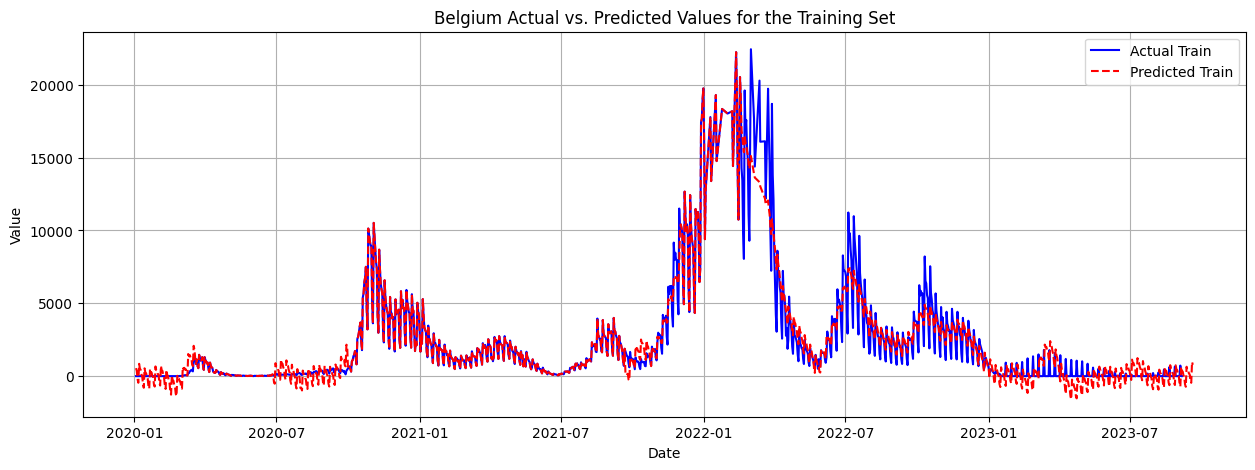

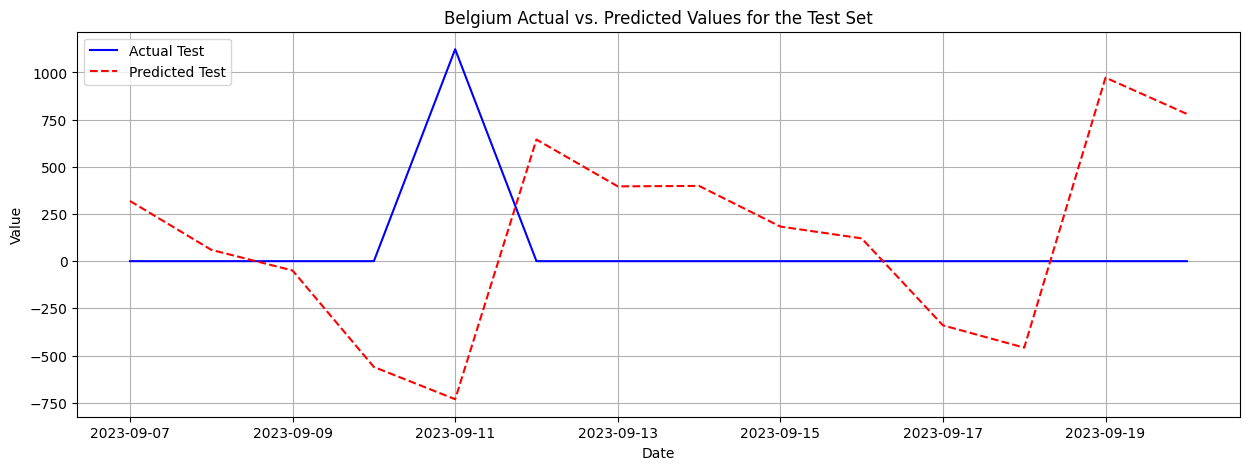

In [44]:
# Assuming 'ds' is a string representing dates, convert it to datetime
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test['ds'], test['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test)), forecast['yhat'].tail(len(test)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

In [45]:
# Extract the actual and forecasted values for the test set
actual_test_values = test['y'].values
predicted_test_values = forecast['yhat'].tail(len(test)).values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
print(f"RMSE for the test set: {rmse}")

RMSE for the test set: 682.4977543114934


### 10. United Kingdom

# Multiple Regressors